# CFMM liquidity on an orde book

- $f(x, y)$ - the CFMM's invariant function
- $A$ - current pool reserve of the base asset
- $B$ - current pool reserve of the quote asset
- $\Delta p$ - tick size
- $p_{\mathrm{m}}$ - marginal price (or, mid price)
- $p_n$ - the $n$-th tick below $p_{\mathrm{m}}$
- $a_n$ - the cumulative buy quantity from $p_{\mathrm{m}}$ to $p_n$
- $\Delta a_n$ - the size of the buy order at $p_n$

## The general case

$$
\begin{aligned}
p_{\mathrm{m}} &= \frac{\frac{\partial f}{\partial x}}{\frac{\partial f}{\partial y}} \\
p_0 &= p_{\mathrm{m}} \\
p_n &= p_{n-1} - \Delta p \\
a_0 &= 0 \\
a_n &= a: f(A, B) = f(A + a, B - p_n a) \\
\Delta a_0 &= 0 \\
\Delta a_n &= a_n - a_{n-1} \\
\end{aligned}
$$

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def compute_bids(compute_p_m, compute_a_n, A, B, dp, num_ticks, **kwargs):
    p_n = compute_p_m(A, B, **kwargs)
    a_n = 0
    delta_a_n = 0

    arr_p_n = [p_n]
    arr_a_n = [a_n]
    arr_delta_a_n = [delta_a_n]
    
    for n in range(1, num_ticks + 1):
        p_n -= dp
        a_n = compute_a_n(A, B, p_n, **kwargs)
        delta_a_n = a_n - arr_a_n[n - 1]
        arr_p_n.append(p_n)
        arr_a_n.append(a_n)
        arr_delta_a_n.append(delta_a_n)

    return np.array(arr_p_n), np.array(arr_delta_a_n), np.array(arr_a_n)


def compute_asks(compute_p_m, compute_a_n, A, B, dp, num_ticks, **kwargs):
    p_n = compute_p_m(A, B, **kwargs)
    a_n = 0
    delta_a_n = 0

    arr_p_n = [p_n]
    arr_a_n = [a_n]
    arr_delta_a_n = [delta_a_n]

    for n in range(1, num_ticks + 1):
        p_n += dp
        a_n = compute_a_n(A, B, p_n, **kwargs)
        delta_a_n = a_n - arr_a_n[n - 1]
        arr_p_n.append(p_n)
        arr_a_n.append(a_n)
        arr_delta_a_n.append(delta_a_n)

    return np.array(arr_p_n), np.array(arr_delta_a_n), np.array(arr_a_n)


def plot(compute_p_m, compute_bid_a_n, compute_ask_a_n, A, B, dp, num_ticks=25, filename="", **kwargs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    # Compute and plot bids
    prices_bids, order_sizes_bids, depths_bids = compute_bids(compute_p_m, compute_bid_a_n, A, B, dp, num_ticks, **kwargs)
    ax1.bar(prices_bids, order_sizes_bids, color="green", width=dp * 0.8)
    ax2.step(prices_bids, depths_bids, color="green", where="post")

    # Compute and plot asks
    prices_asks, order_sizes_asks, depths_asks = compute_asks(compute_p_m, compute_ask_a_n, A, B, dp, num_ticks, **kwargs)
    ax1.bar(prices_asks, order_sizes_asks, color="red", width=dp * 0.8)
    ax2.step(prices_asks, depths_asks, color="red", where="post")

    ax2.set_xlabel("price ($)")
    ax1.set_ylabel("order size (SOL)")
    ax2.set_ylabel("order depth (SOL)")
    ax2.set_ylim(0)

    plt.tight_layout()
    if filename != "":
        plt.savefig(filename)
    plt.show()

    return zip(prices_bids, order_sizes_bids), zip(prices_asks, order_sizes_asks)


## Xyk

$$
f(x, y) = xy
$$

$$
p_{\mathrm{m}} = \frac{B}{A}
$$

| BUY                        | SELL                      |
| -------------------------- | ------------------------- |
| $a_n = -A + \frac{B}{p_n}$ | $a_n = A - \frac{B}{p_n}$ |

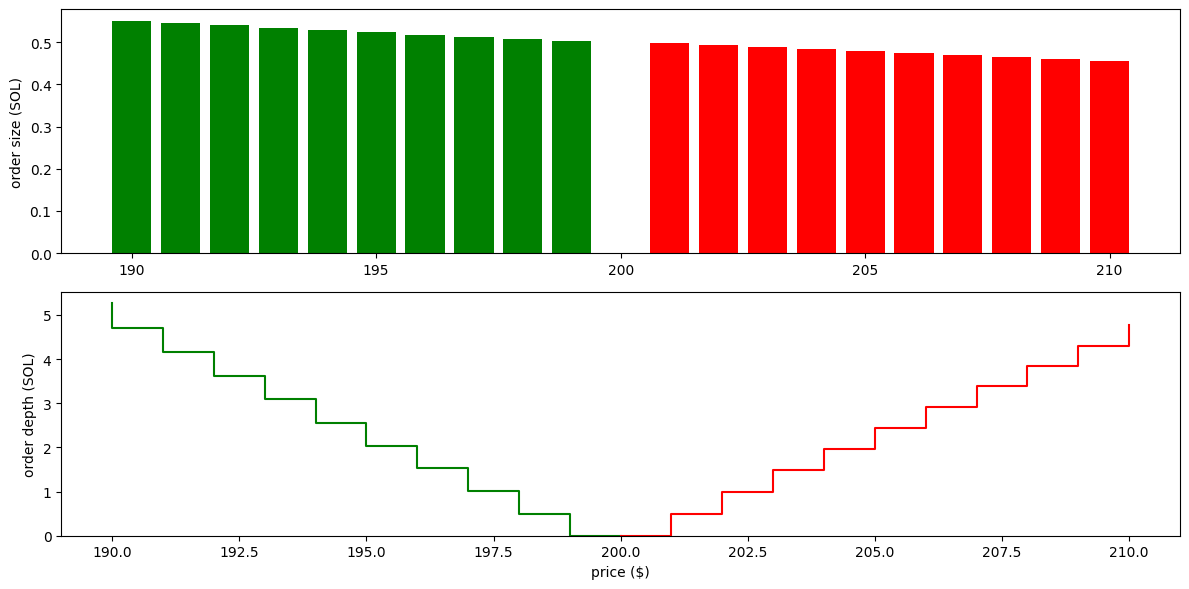

([(200.0, 0),
  (199.0, 50251),
  (198.0, 50759),
  (197.0, 51274),
  (196.0, 51797),
  (195.0, 52329),
  (194.0, 52868),
  (193.0, 53416),
  (192.0, 53972),
  (191.0, 54538),
  (190.0, 55112)],
 [(200.0, 0),
  (201.0, 49751),
  (202.0, 49259),
  (203.0, 48773),
  (204.0, 48295),
  (205.0, 47824),
  (206.0, 47360),
  (207.0, 46902),
  (208.0, 46451),
  (209.0, 46007),
  (210.0, 45568)])

In [26]:
def compute_xyk_f(A, B):
    return A * B


def compute_xyk_p_m(A, B):
    return B / A


def compute_xyk_bid_a_n(A, B, p_n):
    return B / p_n - A


def compute_xyk_ask_a_n(A, B, p_n):
    return A - B / p_n


bids, asks = plot(compute_xyk_p_m,
     compute_xyk_bid_a_n,
     compute_xyk_ask_a_n,
     A=100,
     B=20000,
     dp=1,
     num_ticks=10,
     filename="1-xyk.png")

bids_xyk, asks_xyk = list(map(lambda x: (x[0], int(round(x[1], 5)*100000)), bids)), list(map(lambda x: (x[0], int(round(x[1], 5)*100000)), asks))

bids_xyk, asks_xyk


## Solidly

$$
f(x, y) = x^3 \left(\frac{y}{R}\right) + x \left(\frac{y}{R}\right)^3
$$

$$
p_{\mathrm{m}} = \frac{3 R^2 A^2 B + B^3}{R^2 A^3 + 3 A B^2}
$$

| BUY                                                                                        | SELL                                                                                      |
| ------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------- |
| $\alpha = A + a$                                                                           | $\alpha = A - a$                                                                          |
| $\beta = \frac{B - p a}{R}$                                                                | $\beta = \frac{B + p a}{R}$                                                               |
| $g(a) = \alpha^3 \beta + \alpha \beta^3 - f(A, B)$                                         | $g(a) = \alpha^3 \beta + \alpha \beta^3 - f(A, B)$                                        |
| $g'(a) = -\frac{p}{R} \alpha^3 + a \alpha^2 \beta - \frac{3p}{R} \alpha \beta^2 + \beta^3$ | $g'(a) = \frac{p}{R} \alpha^3 - a \alpha^2 \beta + \frac{3p}{R} \alpha \beta^2 - \beta^3$ |

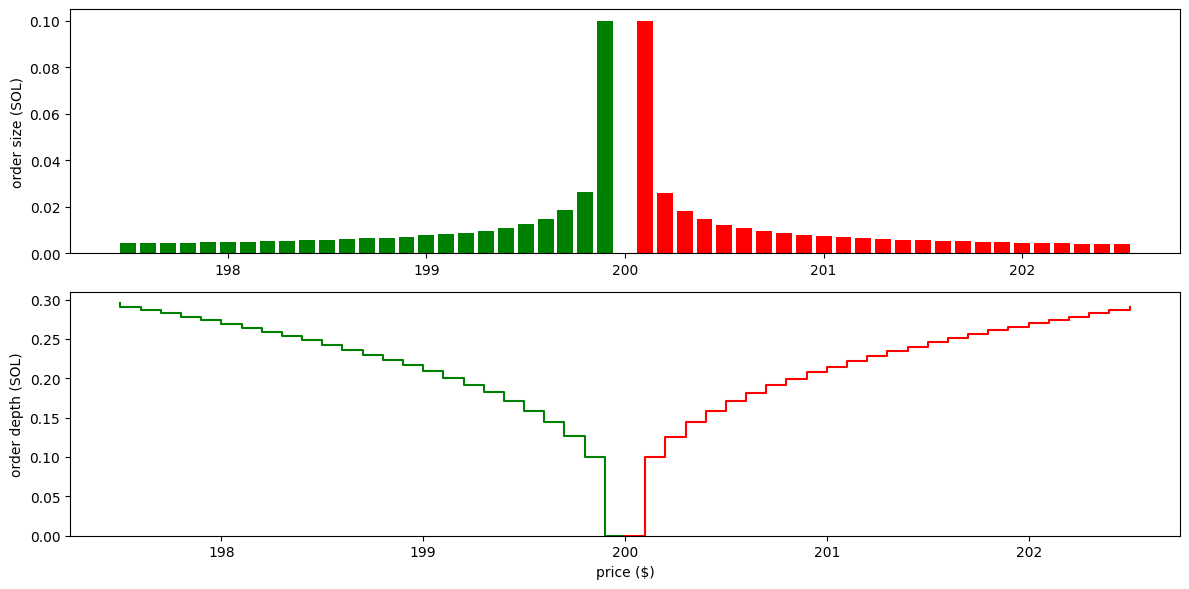

In [3]:
def compute_solidly_f(A, B, R):
    return A * A * A * B / R + A * B * B * B / R / R / R


def compute_solidly_p_m(A, B, R):
    return (3 * R * R * A * A * B + B * B * B) / (R * R * A * A * A + 3 * A * B * B)


def compute_solidly_bid_a_n(A, B, p_n, R, tolerance=1e-6, max_iterations=32):
    K = compute_solidly_f(A, B, R)
    a_prev = A
    for _ in range(max_iterations):
        alpha = A + a_prev
        beta = (B - p_n * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = - p_n * alpha * alpha * alpha / R + 3 * alpha * alpha * beta - 3 * p_n * alpha * beta * beta / R + beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")
    

def compute_solidly_ask_a_n(A, B, p_n, R, tolerance=1e-6, max_iterations=32):
    K = compute_solidly_f(A, B, R)
    a_prev = A
    for _ in range(max_iterations):
        alpha = A - a_prev
        beta = (B + p_n * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = p_n * alpha * alpha * alpha / R - 3 * alpha * alpha * beta + 3 * p_n * alpha * beta * beta / R - beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")


plot(compute_solidly_p_m,
     compute_solidly_bid_a_n,
     compute_solidly_ask_a_n,
     A=1,
     B=200,
     R=200,
     dp=0.1,
     num_ticks=25,
     filename="2-solidly.png")

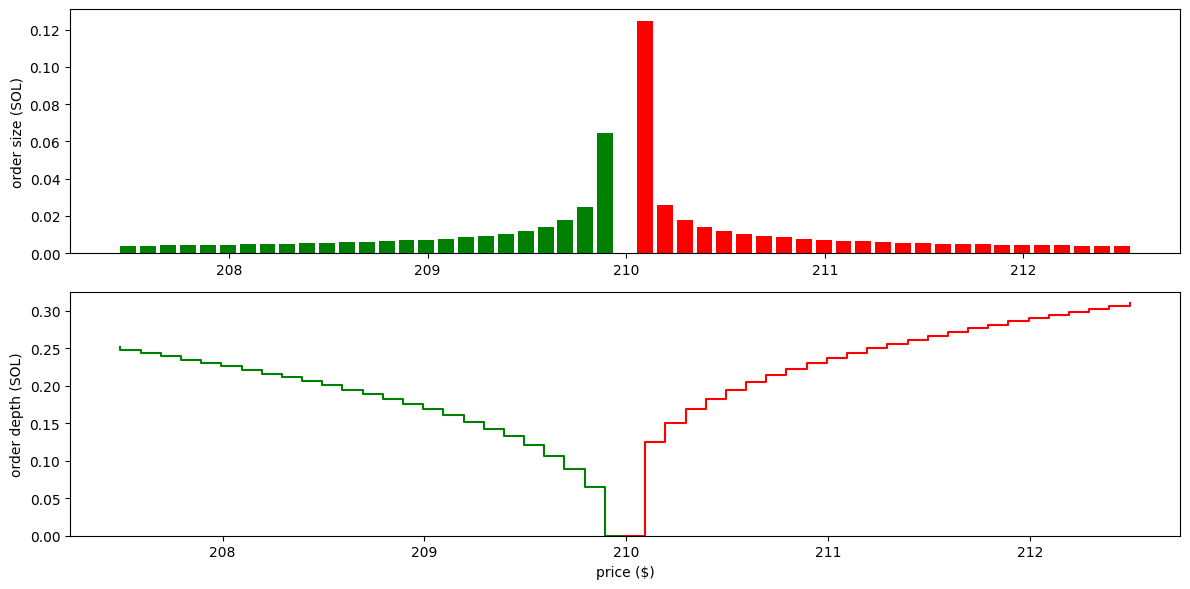

In [4]:
plot(compute_solidly_p_m,
     compute_solidly_bid_a_n,
     compute_solidly_ask_a_n,
     A=1,
     B=200,
     R=210,
     dp=0.1,
     num_ticks=25,
     filename="3-solidly-price-jump.png")

In [15]:
round(0.97068530382451, 5)

0.97069